In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random

from utils import get_celeba
from DCGAN import weights_init, Generator, Discriminator

In [2]:
# Set random seed for reproducibility.
seed = 369
random.seed(seed)
torch.manual_seed(seed)
print("Random Seed: ", seed)

# Parameters to define the model.
params = {
    "bsize" : 128,# Batch size during training.
    'imsize' : 64,# Spatial size of training images. All images will be resized to this size during preprocessing.
    'nc' : 3,# Number of channles in the training images. For coloured images this is 3.
    'nz' : 100,# Size of the Z latent vector (the input to the generator).
    'ngf' : 64,# Size of feature maps in the generator. The depth will be multiples of this.
    'ndf' : 64, # Size of features maps in the discriminator. The depth will be multiples of this.
    'nepochs' : 10,# Number of training epochs.
    'lr' : 0.0002,# Learning rate for optimizers
    'beta1' : 0.5,# Beta1 hyperparam for Adam optimizer
    'save_epoch' : 2}# Save step.

# Use GPU is available else use CPU.
device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
print(device, " will be used.\n")

# Get the data.
dataloader = get_celeba(params)

Random Seed:  369
cpu  will be used.



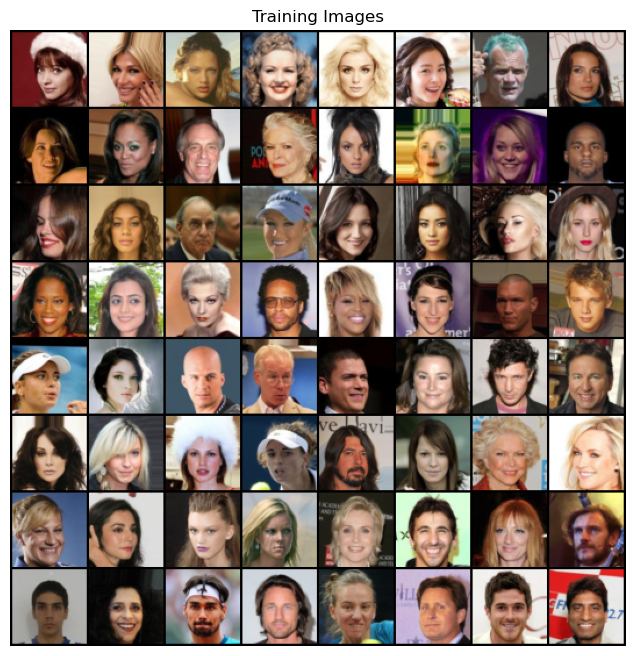

In [3]:
# Plot the training images.
sample_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(
    sample_batch[0].to(device)[ : 64], padding=2, normalize=True).cpu(), (1, 2, 0)))

plt.show()

In [4]:
# Create the generator.
netG = Generator(params).to(device)
# Apply the weights_init() function to randomly initialize all
# weights to mean=0.0, stddev=0.2
netG.apply(weights_init)
# Print the model.
print(netG)

# Create the discriminator.
netD = Discriminator(params).to(device)
# Apply the weights_init() function to randomly initialize all
# weights to mean=0.0, stddev=0.2
netD.apply(weights_init)
# Print the model.
print(netD)

Generator(
  (tconv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)
Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(

In [5]:
# Binary Cross Entropy loss function.
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, params['nz'], 1, 1, device=device)

real_label = 1
fake_label = 0

# Optimizer for the discriminator.
optimizerD = optim.Adam(netD.parameters(), lr=params['lr'], betas=(params['beta1'], 0.999))
# Optimizer for the generator.
optimizerG = optim.Adam(netG.parameters(), lr=params['lr'], betas=(params['beta1'], 0.999))

In [6]:
# Stores generated images as training progresses.
img_list = []
# Stores generator losses during training.
G_losses = []
# Stores discriminator losses during training.
D_losses = []

iters = 0

print("Starting Training Loop...")
print("-"*25)

for epoch in range(params['nepochs']):
    for i, data in enumerate(dataloader, 0):
        # Transfer data tensor to GPU/CPU (device)
        real_data = data[0].to(device)
        # Get batch size. Can be different from params['nbsize'] for last batch in epoch.
        b_size = real_data.size(0)
        
        # Make accumalated gradients of the discriminator zero.
        netD.zero_grad()
        # Create labels for the real data. (label=1)
        label = torch.full((b_size, ), real_label, device=device)
        output = netD(real_data).view(-1)
        errD_real = criterion(output, label)
        # Calculate gradients for backpropagation.
        errD_real.backward()
        D_x = output.mean().item()
        
        # Sample random data from a unit normal distribution.
        noise = torch.randn(b_size, params['nz'], 1, 1, device=device)
        # Generate fake data (images).
        fake_data = netG(noise)
        # Create labels for fake data. (label=0)
        label.fill_(fake_label  )
        # Calculate the output of the discriminator of the fake data.
        # As no gradients w.r.t. the generator parameters are to be
        # calculated, detach() is used. Hence, only gradients w.r.t. the
        # discriminator parameters will be calculated.
        # This is done because the loss functions for the discriminator
        # and the generator are slightly different.
        output = netD(fake_data.detach()).view(-1)
        errD_fake = criterion(output, label)
        # Calculate gradients for backpropagation.
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Net discriminator loss.
        errD = errD_real + errD_fake
        # Update discriminator parameters.
        optimizerD.step()
        
        # Make accumalted gradients of the generator zero.
        netG.zero_grad()
        # We want the fake data to be classified as real. Hence
        # real_label are used. (label=1)
        label.fill_(real_label)
        # No detach() is used here as we want to calculate the gradients w.r.t.
        # the generator this time.
        output = netD(fake_data).view(-1)
        errG = criterion(output, label)
        # Gradients for backpropagation are calculated.
        # Gradients w.r.t. both the generator and the discriminator
        # parameters are calculated, however, the generator's optimizer
        # will only update the parameters of the generator. The discriminator
        # gradients will be set to zero in the next iteration by netD.zero_grad()
        errG.backward()

        D_G_z2 = output.mean().item()
        # Update generator parameters.
        optimizerG.step()

        # Check progress of training.
        if i%50 == 0:
            print(torch.cuda.is_available())
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, params['nepochs'], i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save the losses for plotting.
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on a fixed noise.
        if (iters % 100 == 0) or ((epoch == params['nepochs']-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake_data = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake_data, padding=2, normalize=True))

        iters += 1

    # Save the model.
    if epoch % params['save_epoch'] == 0:
        torch.save({
            'generator' : netG.state_dict(),
            'discriminator' : netD.state_dict(),
            'optimizerG' : optimizerG.state_dict(),
            'optimizerD' : optimizerD.state_dict(),
            'params' : params
            }, 'model/model_epoch_{}.pth'.format(epoch))

Starting Training Loop...
-------------------------


/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.9/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


RuntimeError: Found dtype Long but expected Float

In [ ]:
# Save the final trained model.
torch.save({
            'generator' : netG.state_dict(),
            'discriminator' : netD.state_dict(),
            'optimizerG' : optimizerG.state_dict(),
            'optimizerD' : optimizerD.state_dict(),
            'params' : params
            }, 'model/model_final.pth')

In [ ]:
# Plot the training losses.
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Animation showing the improvements of the generator.
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
plt.show()
anim.save('celeba.gif', dpi=80, writer='imagemagick')